In [1]:
# Run a jupyter server on Newtown with 
# conda activate __
# srun --gres=gpu:L40:1  -c2 jupyter_lab.sh 
# Remotely connect to the kernel from local machine

In [2]:
# !pip install transformers datasets
# !pip install git+https://github.com/neelnanda-io/TransformerLens
# !pip install pytest
# !pip install huggingface_hub
# !pip install seaborn

In [3]:
# Make sure you have at least 30GB. The model itself (llama-2-7b) is 25GB

!nvidia-smi

Fri Mar 22 10:06:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L40S                    On  | 00000000:B4:00.0 Off |                  Off |
| N/A   34C    P0              63W / 350W |      0MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# The first time you run this, you have to login to huggingface.
# Also, your huggingface account should have access to llama-2-7b https://huggingface.co/meta-llama/Llama-2-7b  (First request from Meta 
#   and then from huggingface)

# from huggingface_hub import notebook_login
# notebook_login()

In [1]:
import torch 

device = "cuda" if torch.cuda.is_available() else "cpu"
if not torch.cuda.is_available():
    print("WARNING: Running on CPU")

In [2]:
from transformers import AutoModelForCausalLM, LlamaTokenizer, AutoTokenizer
from tqdm.notebook import tqdm
from jaxtyping import Float

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer

from datasets import load_dataset
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from einops import einsum
from dataclasses import dataclass
import re

Transformer Lens Library is too buggy with large models, scroll down until you find LLama7BHelper and work with that

In [7]:
# Working with the Transformer Lens library

# https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/LLaMA.ipynb#scrollTo=WuzUQA3wzthK

LLAMA_2_7B_PATH = 'meta-llama/Llama-2-7b-hf'

# tokenizer = AutoTokenizer.from_pretrained(LLAMA_2_7B_PATH)
# hf_model = AutoModelForCausalLM.from_pretrained(LLAMA_2_7B_PATH, low_cpu_mem_usage=True)

# model = HookedTransformer.from_pretrained(LLAMA_2_7B_PATH, device=device, fold_ln=False, center_writing_weights=False, center_unembed=False)
model = HookedTransformer.from_pretrained('gpt2-small', device=device, fold_ln=False, center_writing_weights=False, center_unembed=False)
model.generate("The capital of Germany is", max_new_tokens=20, temperature=0)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


  0%|          | 0/20 [00:00<?, ?it/s]

'The capital of Germany is now home to a new breed of German-made cars, with the latest model being the BMW M'

In [8]:
print(f' {torch.cuda.memory_allocated() / 2**30} GB')

 25.73937702178955 GB


In [9]:
model.cfg.use_attn_in = False
model.cfg.use_split_qkv_input = False
model.cfg.use_attn_result = False
model.cfg.use_hook_mlp_in = False

In [3]:
# Preparing the AGNEWS dataset. Uncomment below and run once
# Note, your terminal should be running one directory above the git repo top-level directory ICL-GD

AG_NEWS_LABEL_TO_WORD = {
    0: 'World',
    1: 'Sports',
    2: 'Business',
    3: 'Technology',
}

AG_NEWS_INSTRUCTION = 'Classify the news articles into the categories of World, Sports, Business, and Technology.\n'


def prepare_icl_dataset(ds, n_demonstrations, n_prompts, seed=None):
    # Same seed guarantees same random sampling from ag_news dataset.
    # Order of sampling: 1.test prompt 2. demonstrations
    icl_ds = []
    rng = np.random.default_rng(seed=seed)
    test_indices = rng.choice(len(ds), size=(n_prompts,), replace=False)
    for i in range(n_prompts):
        icl_prompt = AG_NEWS_INSTRUCTION
        zsl_prompt = icl_prompt

        test_index = int(test_indices[i])
        test_data_point = ds[test_index]
        indices_wo_test = list(range(len(ds)))
        indices_wo_test.remove(test_index)
        test_text, test_label = test_data_point['text'], AG_NEWS_LABEL_TO_WORD[test_data_point['label']]

        dem_indices = rng.choice(indices_wo_test, size=(n_demonstrations, ), replace=False)
        for j in range(n_demonstrations):
            data_point = ds[int(dem_indices[j])]
            text, label = data_point['text'], AG_NEWS_LABEL_TO_WORD[data_point['label']]
            icl_prompt += f"News: {text}\nCategory: {label}\n"
        zsl_prompt += f"News: {test_text}\nCategory:"
        icl_prompt += f"News: {test_text}\nCategory:"
        icl_ds.append({'ICL Prompt': icl_prompt, 'ZSL Prompt': zsl_prompt,'Answer': test_label})
    icl_ds = pd.DataFrame(icl_ds)
    return icl_ds

# dataset = load_dataset('ag_news')
# ds_train = dataset['train']
# ds_test = dataset['test']
# print(ds_train[0])
# icl32_ds = prepare_icl_dataset(ds_train, 32, 100, seed=0)
# icl32_ds.to_csv('ICL-GD/ICL-AGNews-Size100-32Dem.csv')
# icl16_ds = prepare_icl_dataset(ds_train, 16, 100, seed=0)
# icl16_ds.to_csv('ICL-GD/ICL-AGNews-Size100-16Dem.csv')
# icl8_ds = prepare_icl_dataset(ds_train, 8, n_prompts=100, seed=0)
# icl8_ds.to_csv('ICL-GD/ICL-AGNews-Size100-8Dem.csv')
# icl4_ds = prepare_icl_dataset(ds_train, 4, n_prompts=100, seed=0)
# icl4_ds.to_csv('ICL-GD/ICL-AGNews-Size100-4Dem.csv')

# assert icl32_ds.loc[85, 'ZSL Prompt'] == icl16_ds.loc[0, 'ZSL Prompt']
# print(f"ICL Prompt:\n {icl_ds.loc[0, 'ICL Prompt']}")
# print(f"ZSL Prompt:\n {icl_ds.loc[0, 'ZSL Prompt']}")
# print("Answer: ", icl_ds.loc[0, 'Answer'])

In [15]:
icl_ds = pd.read_csv('ICL-GD/ICL-AGNews-Size100-8Dem.csv')

In [16]:
# ZSL fails

zsl_prompt_tokens = model.to_tokens(icl_ds.loc[1, 'ZSL Prompt']).detach().cpu()
zsl_out = model.generate(zsl_prompt_tokens, max_new_tokens=1, temperature=0, verbose=False).squeeze()
print(model.to_string(zsl_out))

<|endoftext|>Classify the news articles into the categories of World, Sports, Business, and Technology.
News: AMD introduces low-cost Internet device Chip company Advanced Micro Devices Inc. on Thursday rolled out a low-cost Internet device aimed at underserved markets around the world.
Category: News


In [17]:
# ICL succeeds

icl_prompt_tokens = model.to_tokens(icl_ds.loc[1, 'ICL Prompt']).detach().cpu()
icl_out = model.generate(icl_prompt_tokens, max_new_tokens=1, temperature=0, verbose=False).squeeze()
out_str = model.to_string(icl_out)
print(f'{out_str[0:100]}...\n...\n...{out_str[-400:]}')

<|endoftext|>Classify the news articles into the categories of World, Sports, Business, and Technolo...
...
...University.
Category: Technology
News: Doctors wait for irritation to disappear Surgery on the Red Sox pitcher Curt Schilling #39;s right ankle apparently has been delayed at least a week because of an irritation in the area of the torn tendon sheath that is to be repaired.
Category: Sports
News: AMD introduces low-cost Internet device Chip company Advanced Micro Devices Inc. on Thursday announced


In [18]:
def model_accuracy_icl_zsl(model, ds, test_size, seed=None):
    correct_icl = 0
    correct_zsl = 0
    rng = np.random.default_rng(seed=seed)
    indices = rng.choice(len(ds), size=(test_size,), replace=False)
    for i in tqdm(indices):
        row = ds.iloc[i]
        icl_prompt_tokens = model.to_tokens(row['ICL Prompt']).detach().cpu()
        zsl_prompt_tokens = model.to_tokens(row['ZSL Prompt']).detach().cpu()
        # out = model(prompt_tokens)
        # print(type(out))
        icl_out = model.generate(icl_prompt_tokens, max_new_tokens=1, temperature=0, verbose=False).squeeze()
        zsl_out = model.generate(zsl_prompt_tokens, max_new_tokens=1, temperature=0, verbose=False).squeeze()
        # print(f'Model: {model.to_string(out[0, -1])}, Answer: {row['Answer']}')
        # print(out.size())
        correct_icl += (model.to_string(icl_out[-1]) == row['Answer'])
        correct_zsl += (model.to_string(zsl_out[-1]) == row['Answer'])

    print(f'ICL accuracy: {correct_icl / test_size}')
    print(f'ZSL accuracy: {correct_zsl / test_size}')

In [19]:
# Accuracy of  ICL, vs ZSL (note: different datasets, hence ZSL performance slightly different)
# 8 demonstrations is already excellent

for n_dems in (4, 8, 16, 32):
    print(f'{n_dems} demonstrations:')
    icl_ds = pd.read_csv(f'ICL-GD/ICL-AGNews-Size100-{n_dems}Dem.csv')
    model_accuracy_icl_zsl(model, icl_ds, test_size=50, seed=0)

4 demonstrations:


  0%|          | 0/50 [00:00<?, ?it/s]

ICL accuracy: 0.0
ZSL accuracy: 0.0
8 demonstrations:


  0%|          | 0/50 [00:00<?, ?it/s]

ICL accuracy: 0.0
ZSL accuracy: 0.0
16 demonstrations:


  0%|          | 0/50 [00:00<?, ?it/s]

ICL accuracy: 0.0
ZSL accuracy: 0.0
32 demonstrations:


  0%|          | 0/50 [00:00<?, ?it/s]

ICL accuracy: 0.0
ZSL accuracy: 0.0


In [16]:
# Transpose of embedding matrix actually works better than the unembedding matrix for the clean token embeddings
# But probably not after layers

W_embedding = model.W_E.to(device)
W_unembedding = model.W_U.to(device)
n_vocab = W_embedding.shape[0]
print(W_embedding.shape)
print(W_unembedding.shape)
tokens = model.to_tokens('Transformers').to(device)
print(model.to_string(tokens))
print(tokens.shape)
tokens_one_hot = torch.nn.functional.one_hot(tokens, num_classes=n_vocab).float()
print(tokens_one_hot.shape)
assert torch.all(torch.argmax(tokens_one_hot, dim=-1) == tokens)
embeddings = torch.matmul(tokens_one_hot, W_embedding)
print(embeddings.shape)
back_to_tokens_one_hot = torch.matmul(embeddings, W_unembedding)
back_to_tokens_one_hot_2 = torch.matmul(embeddings, W_embedding.T)
back_to_tokens = torch.argmax(back_to_tokens_one_hot, dim=-1)
back_to_tokens_2 = torch.argmax(back_to_tokens_one_hot_2, dim=-1)
back_to_words = model.to_string(back_to_tokens)
back_to_words_2 = model.to_string(back_to_tokens_2)
print(back_to_words)
print(back_to_words_2)

torch.Size([32000, 4096])
torch.Size([4096, 32000])
['<s> Transformers']
torch.Size([1, 4])
torch.Size([1, 4, 32000])
torch.Size([1, 4, 4096])
['Institutionfigattedhips']
['<s> Transformers']


In [17]:
token_tensor = model.generate('The capital of Germany is', max_new_tokens=3, temperature=0, return_type='tensor').squeeze()
print(model.to_string(token_tensor[:-2]))
print(model.to_string(token_tensor[:-1]))
print(model.to_string(token_tensor))

  0%|          | 0/3 [00:00<?, ?it/s]

<s> The capital of Germany is Berlin
<s> The capital of Germany is Berlin.
<s> The capital of Germany is Berlin. Berlin


In [12]:
import sys
print(sys.version)

3.12.2 | packaged by Anaconda, Inc. | (main, Feb 27 2024, 17:35:02) [GCC 11.2.0]


In [3]:
# LLAMA_2_7B_PATH = 'meta-llama/Llama-2-7b-hf'
PYTHIA_PATH = 'EleutherAI/pythia-6.9b-v0'
# hf_model = AutoModelForCausalLM.from_pretrained(LLAMA_2_7B_PATH, low_cpu_mem_usage=True)
model = HookedTransformer.from_pretrained(model_name=PYTHIA_PATH, device=device)

config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/42.0k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.91G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model EleutherAI/pythia-6.9b-v0 into HookedTransformer


In [8]:
# model = HookedTransformer.from_pretrained('gpt2-small', device=device, fold_ln=False, center_writing_weights=False, center_unembed=False)
# model = HookedTransformer.from_pretrained('gpt2-small', device=device, fold_ln=False, center_unembed=True)

# model = HookedTransformer.from_pretrained(LLAMA_2_7B_PATH, device=device, fold_ln=True, center_unembed=False, center_writing_weights=False, fold_value_biases=False)
prompt = 'The capital of Germany is'
logits, activation_cache = model.run_with_cache(prompt, return_cache_object=True, remove_batch_dim=True)
logits = logits.squeeze(dim=0)
accum_resid, labels = activation_cache.accumulated_resid(return_labels=True, apply_ln=True)
unembedded = accum_resid @ model.W_U + model.b_U
print(unembedded.shape)  # Layer, pos, d_model
unembedded_last_layer = unembedded[-1, :, :]
assert logits.shape == unembedded_last_layer.shape

print(logits[-1, :5])
print(unembedded_last_layer[-1, :5])

print(((logits - unembedded_last_layer) / logits)[~torch.isclose(logits, unembedded_last_layer, rtol=1e-2)])



torch.Size([33, 6, 50432])
tensor([ 3.7533, -3.5945,  5.3853,  4.7549,  1.2172], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([ 3.7533, -3.5945,  5.3853,  4.7549,  1.2172], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([-0.0123, -0.0102, -0.0152, -0.0151, -0.0108, -0.0152, -0.0274, -0.5511,
        -0.0113], device='cuda:0', grad_fn=<IndexBackward0>)


In [23]:
# Let's try to see the output for each layer - https://neelnanda-io.github.io/TransformerLens/generated/code/transformer_lens.ActivationCache.html#transformer_lens.ActivationCache.ActivationCache.accumulated_resid

# Something is weird with the unembedding, it seems like it's not just as simple as multiplying by the unembedding matrix, because
# doing that on the last layer doesn't yield the model's outputs

def layer_prob(prompt):
    with torch.no_grad():
        logits, activation_cache = model.run_with_cache(prompt, return_cache_object=True)
        final_answer_token = int(torch.argmax(logits[0, -1]))
        # print(activation_cache.cache_dict.keys())
        # print(logits.shape)
        # print(logits[0, -1, :5])
        # print(activation_cache.cache_dict['ln_final.hook_normalized'].shape)
        # manual_logits = activation_cache.cache_dict['ln_final.hook_normalized'] / activation_cache['ln_final.hook_scale'] @ W_unembedding

        # print()
        # print(torch.argmax(logits[0, -1, :]))
        # print(torch.argmax(manual_logits[0, -1, :]))

        # print(manual_logits.shape)
        # print(manual_logits[0, -1, :5])

        # print((logits / manual_logits)[0, -1, :5])


        # assert torch.equal(logits, manual_logits)

        print(model.to_string(torch.argmax(logits[0, -1])))
        accum_resid, labels = activation_cache.accumulated_resid(return_labels=True, apply_ln=False)
        return accum_resid, labels, logits, activation_cache
        last_token_accum = accum_resid[:, 0, -1, :]  # layer, batch, pos, d_model
        # print(last_token_accum.shape)  # layer, d_model
        last_token_unembedded = last_token_accum @ W_unembedding  # layer, d_vocab
        # print(last_token_unembedded[-1, :5])
        # assert last_token_unembedded[-1, :].shape == logits[0, -1].shape

        plt.scatter(last_token_unembedded[-1].cpu(), logits[0, -1].cpu())

        # print((last_token_unembedded[-1, :5] / manual_logits[0, -1, :5]))

        # assert torch.equal(last_token_unembedded[-1, :], logits[0, -1])
        probs = torch.softmax(last_token_unembedded, dim=-1)      # layer, d_vocab (probs)
        # last_token_vocab_index = torch.argmax(last_token_unembedded, dim=-1, keepdim=True)
        # print(model.to_string(final_answer_token))
        # print(model.to_string(last_token_vocab_index))
        # print(probs[:, final_answer_token])
        return probs[:, final_answer_token]
        plt.plot(list(range(probs.shape[0])), list(probs[:, final_answer_token].cpu()))
        plt.semilogy()
        plt.title('Confidence in Final Answer By Layer')


In [25]:
accum_resid, labels, logits, activation_cache = layer_prob("The capital of Germany is")

Berlin


In [41]:
print(activation_cache.keys())

dict_keys(['hook_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_rot_q', 'blocks.0.attn.hook_rot_k', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_pre_linear', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_rot_q', 'blocks.1.attn.hook_rot_k', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.m

In [40]:
print(logits[0, -1, :5])
last_token_accum = accum_resid[-1, 0, -1]
print(activation_cache['ln_final.hook_scale'].shape)
last_token_accum = last_token_accum * torch.rsqrt(last_token_accum.pow(2).mean(-1, keepdim=True) + 1e-6)
last_token_accum = last_token_accum * torch.sqrt(activation_cache['ln_final.hook_scale'][0, -1, 0])
unembedded = last_token_accum @ W_unembedding
(unembedded / logits[0, -1])[:5]

tensor([ -9.5833, -11.0975,   4.4770,  -3.4971,  -3.1493], device='cuda:0')
torch.Size([1, 6, 1])


tensor([1.0341, 1.0428, 1.1330, 0.9819, 0.8857], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [19]:
icl_ds = pd.read_csv(f'ICL-GD/ICL-AGNews-Size100-8Dem.csv').drop(columns=['Unnamed: 0'])

In [20]:
# Model succeeds on item 63 - if you don't believe me run the code below

i = 63

# rng = np.random.default_rng(seed=0)
# while True:
#     i = rng.integers(len(icl_ds))
#     print(i)
#     prompt = icl_ds['ICL Prompt'][i]
#     answer = icl_ds['Answer'][i]
#     icl_prompt_tokens = model.to_tokens(prompt).detach().cpu()
#     icl_out = model.generate(icl_prompt_tokens, max_new_tokens=1, temperature=0, verbose=False).squeeze()
#     if model.to_string(icl_out[-1]) == answer:
#         print('Found!')
#         break

Classify the news articles into the categories of World, Sports, Business, and Technology.
News: EMC Makes SMB, Channel, Macintosh Play With Dantz Acquisition EMC scored a triple-play with the acquisition of Dantz Development, a small developer of data backup and restore software under the Retrospect brand.
Category: Technology
News: Legal peer-to-peer services: Gimmick or Genius? Few in the tech world need an introduction to Napster #39;s founder, the college dropout whose revolutionary file-swapping technology shook the foundations of the \$11bn record industry.
Category: Technology
News: ONGC #39;s 10th acquisition abroad Public sector behemoth Oil and Natural Gas Corporation Ltd on Monday said it has acquired an offshore oil field in Western Australia.
Category: Business
News: Novell, Microsoft settle row Novell Inc. of Waltham is getting a half-billion-dollar check from Microsoft Corp. to settle an antitrust case that #39;s never been filed.
Category: Business
News: Weakened Arafa

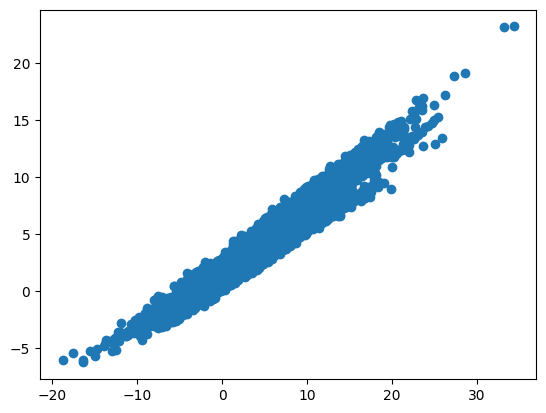

In [30]:
prompt = icl_ds.loc[i, 'ICL Prompt']
print(prompt)
probs = layer_prob(prompt)

In [42]:
plt.plot(probs.cpu())
plt.set_title('Confidence Level per Layer')

NameError: name 'probs' is not defined

# Llama7BHelper
Llama 2 7b Wrapper Taken from https://github.com/nrimsky/LM-exp/tree/main/intermediate_decoding

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.nn.modules.container import ModuleList


# class PermutationLayer(torch.nn.Module):
#     def __init__(self, perm):
#         '''
#         :params perm: int tensor of size (seq_length, ) that speficies the permutation to apply to the layer
#         '''
#         self.perm = perm.to(device)
#         super().__init__()
    
#     def forward(self, *args, **kwargs):
#         input = args[0]         # Input of size (batch, seq_length, d_model)
#         return input[:, self.perm, :]

@dataclass
class PermutationIntervention:
    perm: torch.tensor          # int tensor of size (seq_length, ) that speficies the permutation to apply to the layer
    before_layer_num: int       # The layer number of the transformer (1st is 0) before which to perform permutation


class AttnWrapper(torch.nn.Module):
    def __init__(self, attn, save_all=False):
        super().__init__()
        self.attn = attn
        self.activations = None
        self.add_tensor = None
        self.save_all = save_all

    def forward(self, *args, **kwargs):
        output = self.attn(*args, **kwargs)
        if self.add_tensor is not None:
            output = (output[0] + self.add_tensor,)+output[1:]
        if self.save_all:
            self.activations = output[0]
        return output

    def reset(self):
        self.activations = None
        self.add_tensor = None

class BlockOutputWrapper(torch.nn.Module):
    def __init__(self, block, unembed_matrix, norm, save_all=False):
        super().__init__()
        self.block = block
        self.unembed_matrix = unembed_matrix
        self.norm = norm

        self.block.self_attn = AttnWrapper(self.block.self_attn, save_all=save_all)
        self.post_attention_layernorm = self.block.post_attention_layernorm

        self.attn_mech_output_unembedded = None
        self.intermediate_res_unembedded = None
        self.mlp_output_unembedded = None
        self.block_output_unembedded = None

        self.permutation = None
        self.save_all = save_all


    def forward(self, *args, **kwargs):
        input = args[0]   # (batch, seq_length, d_model)
        if self.permutation is not None:
            # prev_input = input
            input = input[:, self.permutation, :]
            # assert not torch.all(torch.isclose(prev_input, input))
        output = self.block(input, *args[1:], **kwargs)
        self.block_output_unembedded = self.unembed_matrix(self.norm(output[0]))
        if self.save_all:
            attn_output = self.block.self_attn.activations
            self.attn_mech_output_unembedded = self.unembed_matrix(self.norm(attn_output))
            attn_output += input
            self.intermediate_res_unembedded = self.unembed_matrix(self.norm(attn_output))
            mlp_output = self.block.mlp(self.post_attention_layernorm(attn_output))
            self.mlp_output_unembedded = self.unembed_matrix(self.norm(mlp_output))
        return output

    def attn_add_tensor(self, tensor):
        self.block.self_attn.add_tensor = tensor
    
    def add_permutation(self, perm):
        self.permutation = perm
    
    def clean_permutation(self):
        self.permutation = None

    def reset(self):
        self.block.self_attn.reset()
        self.permutation = None

    def get_attn_activations(self):
        return self.block.self_attn.activations

class Llama7BHelper:
    def __init__(self, model, token=None):
        '''
        model: "meta-llama/Llama-2-7b-hf" model
        '''
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf", use_auth_token=token)
        self.model = model
        self.orig_model_layers = self.model.model.layers
        self.model.model.layers = ModuleList(
            [BlockOutputWrapper(layer, self.model.lm_head, self.model.model.norm) for layer in self.model.model.layers]
        )

    def generate_text(self, prompt, max_length=100):
        inputs = self.tokenizer(prompt, return_tensors="pt")
        generate_ids = self.model.generate(inputs.input_ids.to(self.device), max_length=max_length)
        return self.tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]


    def forward(self, prompt, interventions=[]):
        inputs = self.tokenizer(prompt, return_tensors="pt")
        input_ids = inputs['input_ids'][0]
        for intrv in interventions:
            if isinstance(intrv, PermutationIntervention):
                assert intrv.perm.shape[0] == len(input_ids), f'Permutation index list of size {alt.perm.shape[0]} but input sequence of length {len(input_ids)}'
                self.layers[intrv.before_layer_num].add_permutation(intrv.perm)
            else:
                raise NotImplementedError
        with torch.no_grad():
            logits = self.model(inputs.input_ids.to(self.device)).logits
            # Cleanup
            for intrv in interventions:
                if isinstance(intrv, PermutationIntervention):
                    self.layers[intrv.before_layer_num].clean_permutation()
            return logits

    def set_add_attn_output(self, layer, add_output):
        self.model.model.layers[layer].attn_add_tensor(add_output)

    def get_attn_activations(self, layer):
        return self.model.model.layers[layer].get_attn_activations()

    def reset_all(self):
        for layer in self.model.model.layers:
            layer.reset()

    def print_decoded_activations(self, decoded_activations, label, topk=10):
        softmaxed = torch.nn.functional.softmax(decoded_activations[0][-1], dim=-1)
        values, indices = torch.topk(softmaxed, topk)
        probs_percent = [int(v * 100) for v in values.tolist()]
        tokens = self.tokenizer.batch_decode(indices.unsqueeze(-1))
        print(label, list(zip(tokens, probs_percent)))
    
    @property
    def layers(self):
        return self.model.model.layers
    
    @layers.setter
    def layers(self, layers):
        self.model.model.layers = layers


    def decode_all_layers(self, text, topk=10, print_attn_mech=True, print_intermediate_res=True, print_mlp=True, print_block=True):
        self.get_logits(text)
        for i, layer in enumerate(self.model.model.layers):
            print(f'Layer {i}: Decoded intermediate outputs')
            if print_attn_mech:
                self.print_decoded_activations(layer.attn_mech_output_unembedded, 'Attention mechanism', topk=topk)
            if print_intermediate_res:
                self.print_decoded_activations(layer.intermediate_res_unembedded, 'Intermediate residual stream', topk=topk)
            if print_mlp:
                self.print_decoded_activations(layer.mlp_output_unembedded, 'MLP output', topk=topk)
            if print_block:
                self.print_decoded_activations(layer.block_output_unembedded, 'Block output', topk=topk)
    
    def reset_hf_model(self):
        self.model.model.layers = self.orig_model_layers

In [4]:
hf_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf").to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
# model.reset_hf_model()  # Uncomment if you want to rebuild llama7bhelper without reloading hf model
model = Llama7BHelper(hf_model)

In [7]:
# orig_layers = model.layers
# model.model.model.layers = model.layers + model.layers
# model.model.model.layers = orig_layers
# assert(len(model.layers) == 32)

In [6]:
def get_prob_lens(model : Llama7BHelper):
    '''
    Returns tensor of size (layer, pos, d_vocab) with probability distribution predictions for each token,
            in each layer. ASSUMES model.forward() has been run prior to function, and reset_all() has not been called
    '''
    layer_probs = []
    for layer in model.layers:
        inter_logits = layer.block_output_unembedded.squeeze(dim=0)   # pos, d_vocab
        inter_probs = torch.softmax(inter_logits, dim=-1)
        layer_probs.append(inter_probs)
    return torch.stack(layer_probs)

In [7]:
def plot_icl_zsl_confidence(model, icl_prompt, zsl_prompt, correct_answer_str, icl_probs, zsl_probs):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle('Confidence in Final Answer Per Layer')
    for i, prompt in enumerate((icl_prompt, zsl_prompt)):
        print(prompt)
        prompt_type = 'ICL' if prompt == icl_prompt else 'ZSL'
        prob_lens = icl_probs if prompt == icl_prompt else zsl_probs
        final_answer_token = torch.argmax(prob_lens[-1, -1])
        final_answer_str = model.tokenizer.batch_decode(final_answer_token.unsqueeze(0))[0]
        print(f'Model Answer: {final_answer_str}, Correct Answer: {correct_answer_str}')
        correct = final_answer_str == correct_answer_str
        correct_str = "Correct" if correct else "Wrong"
        correct_answer_token = model.tokenizer.encode(text=correct_answer_str, add_special_tokens=False)[0]
        if correct:
            assert correct_answer_token == final_answer_token, (correct_answer_token, final_answer_token)
        

        final_answer_confidence = prob_lens[:, -1, final_answer_token].cpu()
        correct_answer_confidence = prob_lens[:, -1, correct_answer_token].cpu()
        
        for j in (0, 1):
            ax[i][j].plot(final_answer_confidence, label=f'Final ({correct_str}) Answer')
            if not correct:
                ax[i][j].plot(correct_answer_confidence, label='Correct Answer')
            ax[i][j].set_title(f'{"Log " if j == 1 else ''}Confidence - {prompt_type}')
            if j == 1:
                ax[i][j].semilogy()
            ax[i][j].legend()
    return fig, ax

In [8]:
def get_dem_begin_indices(model, icl_prompt):
    '''
    Returns list of indices in token list in which each demonstration of the icl prompt starts (including test prompt)
    '''
    ret = []
    start_idxs = [m.start() for m in re.finditer('\nNews', icl_prompt)]
    for idx in start_idxs:
        tokens = model.tokenizer.encode(icl_prompt[:idx])
        ret.append(len(tokens))
    return ret

def get_random_dem_permutation(model, icl_prompt, seed=None):
    '''
    Returns permutation indexes than can be applied to the encoding of icl_prompt in order to shuffle the demonstrations
    '''
    ret = []
    rng = np.random.default_rng(seed=seed)
    dem_begin_indices = get_dem_begin_indices(model, icl_prompt)
    dem_order = np.arange(0, len(dem_begin_indices) - 1)  # Not including test prompt
    rng.shuffle(dem_order)
    ret += list(np.arange(0, dem_begin_indices[0]))
    for old_pos in dem_order:
        ret += list(
            np.arange(dem_begin_indices[old_pos], dem_begin_indices[old_pos + 1])
        )
    orig_tokens = model.tokenizer.encode(icl_prompt)
    ret += list(np.arange(dem_begin_indices[-1], len(orig_tokens)))
    assert len(ret) == len(orig_tokens)
    return torch.tensor(ret)

def get_semi_preserving_permutation(model, icl_prompt, seed=None):
    '''
    Returns permutation that jumbles up everything after the initial instruction and before the final test prompt.
    '''
    ret = []
    rng = np.random.default_rng(seed=seed)
    dem_begin_indices = get_dem_begin_indices(model, icl_prompt)
    all_middle_indices = np.arange(start=dem_begin_indices[0], stop=dem_begin_indices[-1])
    rng.shuffle(all_middle_indices)
    ret += list(np.arange(0, dem_begin_indices[0]))
    ret += list(all_middle_indices)
    orig_tokens = model.tokenizer.encode(icl_prompt)
    ret += list(np.arange(dem_begin_indices[-1], len(orig_tokens)))
    assert len(ret) == len(orig_tokens)
    return torch.tensor(ret)

def get_non_preserving_permutation(model, icl_prompt, seed=None):
    '''
    Returns permutation that jumbles up literally everything
    '''
    rng = np.random.default_rng(seed=seed)
    orig_tokens = model.tokenizer.encode(icl_prompt)
    indices = np.arange(0, len(orig_tokens))
    rng.shuffle(indices)
    return torch.tensor(indices)


In [9]:
icl_ds = pd.read_csv(f'ICL-GD/ICL-AGNews-Size100-8Dem.csv').drop(columns=['Unnamed: 0'])

In [16]:
print('Before Permutation:')
row = icl_ds.iloc[20]
print(model.tokenizer.decode(model.tokenizer.encode(row['ICL Prompt'])))
perm = get_random_dem_permutation(model, row['ICL Prompt'], seed=0)
after_perm = model.tokenizer.decode(
    np.array(model.tokenizer.encode(row['ICL Prompt']))[perm]
)
print('After Permutation:')
print(after_perm)
print('After Semi Preserving Permutation:')
perm = get_semi_preserving_permutation(model, row['ICL Prompt'], seed=0)
after_perm = model.tokenizer.decode(
    np.array(model.tokenizer.encode(row['ICL Prompt']))[perm]
)
print(after_perm)
print('After Non Preserving Permutation:')
perm = get_non_preserving_permutation(model, row['ICL Prompt'], seed=0)
after_perm = model.tokenizer.decode(
    np.array(model.tokenizer.encode(row['ICL Prompt']))[perm]
)
print(after_perm)

Before Permutation:
<s> Classify the news articles into the categories of World, Sports, Business, and Technology.
News: Report: NHL agent loses certification According to a report in the Ottawa Sun, an NHL agent has lost his certification for leaking information about a players #39; association website to a reporter from a Minnesota newspaper.
Category: Sports
News: Bodies of 49 Iraqi soldiers found The bodies of 49 Iraqi soldiers have been found shot dead Northeast of Baghdad, police and Iraqi National Guard officers said. They said 37 bodies had been recovered on Saturday and another 12 earlier on a 
Category: World
News: LeBron James scores 26 points as Cleveland beats the Bulls 97-74 LeBron James enjoys the Cleveland Cavaliers #39; teamwork even more than his individual accomplishments. One led to the other Saturday night as James scored 26 points to become the youngest player 
Category: Sports
News: Israel Boosts Security for Sharon, Others Israeli soldiers carry the coffin, wrap